## Setup

Load required packages

In [1]:
import pandas as pd
import io
import requests
import numpy as np
import random
import libpysal
import pysal

C:\ProgramData\Anaconda3\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


Read data

In [2]:
#Read from URL (Doesnt work for private repos)
#url="https://github.com/konstantinklemmer/spacegan/raw/master/data/synth_data.csv"
#s=requests.get(url).content
#data=pd.read_csv(io.StringIO(s.decode('utf-8')))

#Read from local file
data=pd.read_csv("C:/Users/Konstantin Klemmer/Documents/GitHub/spacegan/data/synth_data.csv")

In [3]:
data.head(5)

,id,longitude,latitude,y,z
0,1,1.75,1.75,0.980099,1.370958
1,2,5.25,1.75,11.714839,-0.564698
2,3,8.75,1.75,49.355200,0.363128
3,4,12.25,1.75,110.841455,0.632863
4,5,15.75,1.75,196.393346,0.404268


Create a pairwise distance matrix (Euclidean) between the points

In [4]:
dist = pysal.lib.cg.distance_matrix(np.array(data[["longitude","latitude"]]))

Get the `k` smallest distances (of the whole matrix, since the points are equally distributed)

In [5]:
k=10
u_dist = np.unique(dist)
k_min_dist = np.sort(u_dist.flatten())[:k]

In [6]:
k_min_dist

array([ 0.        ,  3.5       ,  4.94974747,  7.        ,  7.82623792,
        9.89949494, 10.5       , 11.06797181, 12.61942946, 14.        ])

Create spatial points object ([KDTree](https://pysal.readthedocs.io/en/dev/library/cg/kdtree.html))). 

In [7]:
import pysal.lib
kd = pysal.lib.cg.kdtree.KDTree(np.array(data[["longitude","latitude"]]))

Compute spatial neighbourhoods weight matrix by distance threshold ("radius")


In [8]:
#wnn = pysal.lib.weights.KNN(kd, 8, ids=data["id"]) #KNN based weights
#wdist= pysal.lib.weights.distance.DistanceBand(kd, threshold=k_min_dist[1],binary=False,p=2) #Rook
wdist= pysal.lib.weights.distance.DistanceBand(kd, threshold=k_min_dist[2],binary=True,p=2) #Queen
#wdist= pysal.lib.weights.distance.DistanceBand(kd, threshold=k_min_dist[4],binary=True,p=2) #Queen 2nd degree

## Spatial CV: Lat/Lon slicing

Create labels based on latitude / longitude binning and add the labels to the original data

In [9]:
data["lon_group"] = pd.cut(data["longitude"],bins=5,labels=[1,2,3,4,5])
data["lat_group"] = pd.cut(data["latitude"],bins=5,labels=[1,2,3,4,5])

This method loops over our lat/lon groups, keeping each group as test data and the rest as train data. However, as we want to do spatial cross-validation, we remove neighbors of the test set. This can help to prevent model overfitting. Here, we remove 1st and 2nd degree neighbors, but the method can be adapted as needed.

In [10]:
for q in list(data)[-2::]: #Loop over the two slicing label columns 
    data["s_id"] = data[q] #Define which label column to use for slicing
    
    for j in np.unique(data["s_id"]): #Loop over the unique labels in the slicing column 
        
        test = data[data["s_id"]==j] #Define test data 
        
        temp_id = [] #Create empty neighbourhood index
        
        for k in test.index: #Fill neighborhood index using first degree neighbors of test data
            temp_id = np.unique(np.concatenate([temp_id,wdist.neighbors[k]]).ravel().astype(np.int32))
            
        for l in temp_id: #Include second degree neighbors
            temp_id = np.unique(np.concatenate([temp_id,wdist.neighbors[l]]).ravel().astype(np.int32))
        
        #for m in temp_id: #Include third degree neighbors
        #    temp_id = np.unique(np.concatenate([temp_id,wdist.neighbors[m]]).ravel().astype(np.int32))
            
        train = data[data["s_id"]!=j] #Define train data 
        train = train.drop(temp_id,errors="ignore") #Exclude neighbors from index
        
        #INSERT DATA AUGMENTATION METHOD HERE
        #train_aug = ...
        
        #INSERT MODEL TRAINING HERE
        #model1 = f(train)
        #predict = predict(model1,test)

Lets take a look at the train and test data in our last iteration:

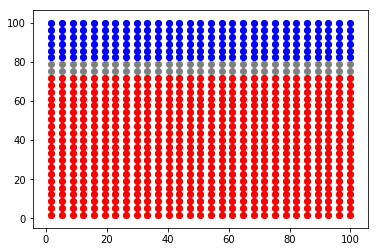

In [11]:
import matplotlib.pyplot as plt
plt.scatter(data["longitude"],data["latitude"],color="grey")
plt.scatter(train["longitude"],train["latitude"],color="red")
plt.scatter(test["longitude"],test["latitude"],color="blue")

## Spatial CV: Leave-one-out (SLOO-CV)

This method loops over every single observation as test points (as leave-one-out does) but excludes the neighbors of each test points. We can again define neighborhood structure as we wish; for now we again exclude 1st and 2nd degree neighbors.

In [12]:
for i in data["id"]:
        
    test = data[data["id"]==i]
        
    temp_id = []
        
    for k in test.index:
        temp_id = np.unique(np.concatenate([temp_id,wdist.neighbors[k]]).ravel().astype(np.int32))
            
        for l in temp_id: #Include second degree neighbors
            temp_id = np.unique(np.concatenate([temp_id,wdist.neighbors[l]]).ravel().astype(np.int32))
        
        #for m in temp_id: #Include third degree neighbors
        #    temp_id = np.unique(np.concatenate([temp_id,wdist.neighbors[m]]).ravel().astype(np.int32))
            
        train = data[data["s_id"]!=i]
        train = train.drop(temp_id,errors="ignore")
        
        #INSERT DATA AUGMENTATION METHOD HERE
        #train_aug = ...
        
        #INSERT MODEL TRAINING HERE
        #model1 = f(train)
        #predict = predict(model1,test)

Let's check how the train and test set look in this case:

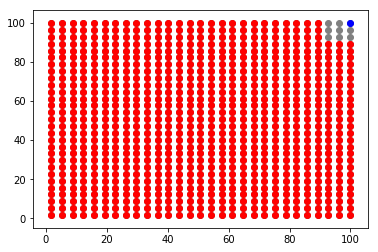

In [13]:
plt.scatter(data["longitude"],data["latitude"],color="grey")
plt.scatter(train["longitude"],train["latitude"],color="red")
plt.scatter(test["longitude"],test["latitude"],color="blue")